In [1]:
!pip install datasets -q
!pip install peft -q
!pip install accelerate -q
!pip install transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

In [2]:
import re
import time
import gc
import ctypes
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.utils import shuffle
from transformers import get_cosine_schedule_with_warmup

2025-08-07 14:25:24.162910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754576724.313526      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754576724.360685      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reward Functions

This is accuracy reward which is rewarded for correct output.

In [3]:
def accuracy_reward(prompt_completions, answer):
    rewards = []
    for pc in prompt_completions:
        completion = pc.split('<answer>')[-1]
        if answer in completion and (pc.count('<answer>') == 2):
            rewards.append(2.0)
        else:
            rewards.append(0.0)
    return rewards

This rewards for maintaining the format.

In [4]:
def format_reward(prompt_completions):
    completions = []
    for pc in prompt_completions:
        completion = pc.split('\nAssistant:')[-1]
        count_eos_string = completion.count(tokenizer.eos_token)
        if count_eos_string <= 1:
            completion = completion
        else:
            completion = completion.replace(tokenizer.eos_token, '')
            completion = completion + tokenizer.eos_token
        completions.append(completion)
    rewards = []
    pattern = re.compile(r".*<reasoning>\n.+?\n</reasoning>\n<answer>\n.+?\n</answer><\|endoftext\|>$", re.DOTALL)
    for completion in completions:
        rewards.append(0.5 if pattern.fullmatch(completion) else 0.0)
    return rewards

## Load and Process Data

In [5]:
import datasets

data = datasets.load_dataset('openai/gsm8k', 'main')

df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

### Extract Answer

In [6]:
df_train['answer'] = df_train['answer'].str.split('####').str[-1].str.strip()
df_test['answer'] = df_test['answer'].str.split('####').str[-1].str.strip()

## Create and Apply Chat Template

In [7]:
SYSTEM = """Assistant, please respond to the user in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

In [8]:
df_train['prompt'] = SYSTEM + 'User: ' + df_train['question'].str.strip() + '\nAssistant:'
df_test['prompt'] = SYSTEM + 'User: ' + df_test['question'].str.strip() + '\nAssistant:'

In [9]:
print(df_train.prompt[69])

Assistant, please respond to the user in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
User: Carly collected 7 starfish with 5 arms each and one seastar with 14 arms. How many arms do the animals she collected have in total?
Assistant:


In [10]:
model_path = 'HuggingFaceTB/SmolLM2-360M' 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [12]:
peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
        bias='none',
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0
    )

model = get_peft_model(model, peft_config)


In [13]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
).eval().requires_grad_(False)

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

## Completion Generation Function

In [15]:
def generate_completions(model, tokenizer, prompts, temperature=0.9, num_completions=2, max_completion_length=50):
    
    model.eval() 
    
    completions = []
    for prompt in tqdm(prompts):

        encodings = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # Generate completions using the current policy
        with torch.inference_mode():
            outs = model.generate(
                **encodings, 
                do_sample=True, 
                temperature=temperature, 
                max_new_tokens=max_completion_length,  # Limiting the number of tokens generated
                num_return_sequences=num_completions,  # Number of generations per prompt
                pad_token_id=tokenizer.eos_token_id
            )
        
        decoded_texts = tokenizer.batch_decode(outs, skip_special_tokens=False)
        completions.extend(decoded_texts)
        
    model.train()
    
    return completions

## Get Log Probs Function

In [16]:
def get_log_probs(model, prompt, prompt_completions, type):
    
    if type == 'new':
        prompt_ids = tokenizer(prompt)
        prompt_len = len(prompt_ids)
        encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)

        with autocast(dtype=torch.bfloat16, device_type='cuda'):
            logits = model(**encodings).logits

    else:
        with torch.no_grad():
            prompt_ids = tokenizer(prompt)
            prompt_len = len(prompt_ids)
            encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)
    
            with autocast(dtype=torch.bfloat16, device_type='cuda'):
                logits = model(**encodings).logits
        
    start = len(tokenizer(prompt).input_ids) 

    all_log_probs = []
    for l, input_ids in zip(logits, encodings.input_ids):
        eos_pos = torch.where(input_ids == tokenizer.eos_token_id)[0]

        if eos_pos.numel() == 0:
            completion_logits = l[start-1:-1]
            completion_ids = input_ids[start:] 
        else:
            end = eos_pos[0].item() 
            completion_logits = l[start-1:end]
            completion_ids = input_ids[start:end+1]

        probs = F.softmax(completion_logits, dim=-1)
        log_probs = torch.log(probs)
        log_probs = torch.gather(log_probs, 1, completion_ids.unsqueeze(1)).squeeze(1)
        all_log_probs.append(log_probs)

    return all_log_probs

In [17]:
def check(t):
    print('ISNAN', torch.isnan(t).any())
    print('ISINF', torch.isinf(t).any())

## Hyperparameters

In [18]:
epochs = 1
n_iterations = 5
learning_rate = 3e-5
weight_decay = 0.005
warmups = 200

eps = 0.2
beta = 0.005

## Training 

In [19]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [20]:
prompts, answers = shuffle(df_train.prompt, df_train.answer)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_training_steps=epochs*len(prompts)*n_iterations,
                                            num_warmup_steps=warmups)

scaler = GradScaler()

In [22]:
start_time = time.time()
max_duration = 3 * 60 * 60  


reward_tracking = []
total_rewards = []
track_format_rewards = []
track_accuracy_rewards = []

step = 0
for epoch in range(epochs):
    for idx in range(len(df_train)):
        step += 1

        if time.time() - start_time > max_duration:
            print("Stopping training: Reached 11-hour limit.")
            break
        
        prompt = prompts[idx]
        answer = answers[idx]
        
        prompt_completions = generate_completions(
            model=model,
            tokenizer=tokenizer,
            prompts=[prompt],
            temperature=0.8, 
            num_completions=5,
            max_completion_length=512)

        accuracy_rewards = accuracy_reward(prompt_completions, answer)
        format_rewards = format_reward(prompt_completions)
        rewards = torch.tensor(accuracy_rewards) + torch.tensor(format_rewards)
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

        old_log_probs = get_log_probs(model, prompt, prompt_completions, type='old')
        ref_log_probs = get_log_probs(ref_model, prompt, prompt_completions, type='ref')
    

        for i_iter in range(n_iterations):
            if time.time() - start_time > max_duration:
                print("Stopping training: Reached 3-hour limit.")
                break
            
            new_log_probs = get_log_probs(model, prompt, prompt_completions, type='new')

            loss = 0
            for i in range(len(old_log_probs)):
                ratio = torch.exp(new_log_probs[i] - old_log_probs[i]) 
                clipped_ratio = torch.clamp(ratio, min=1-eps, max=1+eps)

                kl_ratio1 = torch.exp(ref_log_probs[i] - new_log_probs[i]) 
                kl_ratio2 = torch.exp(ref_log_probs[i] - new_log_probs[i]).log()
                kl = kl_ratio1 - kl_ratio2 - 1
                
                loss += (-clipped_ratio * advantages[i] - beta*kl).mean()
                
            loss = loss / len(new_log_probs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            clean_memory()
            
            print(f"Step: {step} | Iter: {i_iter+1} | Loss", loss.item())

        track_format_rewards.append(sum(format_rewards) / len(format_rewards))
        track_accuracy_rewards.append(sum(accuracy_rewards) / len(accuracy_rewards))
        total_rewards.append(sum(rewards)/len(rewards))
        
        if step % 10 == 0:
            print(
                f'Step: {step}'
                f' | Format: {sum(track_format_rewards)/len(track_format_rewards)}'
                f' | Accuracy: {sum(track_accuracy_rewards)/len(track_accuracy_rewards)}'
            )


            print('Output example:', prompt_completions[0].split('\nAssistant:')[1].strip())

100%|██████████| 1/1 [00:41<00:00, 41.34s/it]


Step: 1 | Iter: 1 | Loss 0.0
Step: 1 | Iter: 2 | Loss 0.0
Step: 1 | Iter: 3 | Loss 0.0
Step: 1 | Iter: 4 | Loss 0.0
Step: 1 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 2 | Iter: 1 | Loss 0.0
Step: 2 | Iter: 2 | Loss 0.0
Step: 2 | Iter: 3 | Loss 0.0
Step: 2 | Iter: 4 | Loss 0.0
Step: 2 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.85s/it]


Step: 3 | Iter: 1 | Loss 0.0
Step: 3 | Iter: 2 | Loss 0.0
Step: 3 | Iter: 3 | Loss 0.0
Step: 3 | Iter: 4 | Loss 0.0
Step: 3 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 4 | Iter: 1 | Loss 0.0
Step: 4 | Iter: 2 | Loss 0.0
Step: 4 | Iter: 3 | Loss 0.0
Step: 4 | Iter: 4 | Loss 0.0
Step: 4 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:39<00:00, 39.90s/it]


Step: 5 | Iter: 1 | Loss 0.0
Step: 5 | Iter: 2 | Loss 0.0
Step: 5 | Iter: 3 | Loss 0.0
Step: 5 | Iter: 4 | Loss 0.0
Step: 5 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 6 | Iter: 1 | Loss 0.0
Step: 6 | Iter: 2 | Loss 0.0
Step: 6 | Iter: 3 | Loss 0.0
Step: 6 | Iter: 4 | Loss 0.0
Step: 6 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 7 | Iter: 1 | Loss 0.0
Step: 7 | Iter: 2 | Loss 0.0
Step: 7 | Iter: 3 | Loss 0.0
Step: 7 | Iter: 4 | Loss 0.0
Step: 7 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 8 | Iter: 1 | Loss 0.0
Step: 8 | Iter: 2 | Loss 0.0
Step: 8 | Iter: 3 | Loss 0.0
Step: 8 | Iter: 4 | Loss 0.0
Step: 8 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.69s/it]


Step: 9 | Iter: 1 | Loss 0.0
Step: 9 | Iter: 2 | Loss 0.0
Step: 9 | Iter: 3 | Loss 0.0
Step: 9 | Iter: 4 | Loss 0.0
Step: 9 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 10 | Iter: 1 | Loss 0.0
Step: 10 | Iter: 2 | Loss 0.0
Step: 10 | Iter: 3 | Loss 0.0
Step: 10 | Iter: 4 | Loss 0.0
Step: 10 | Iter: 5 | Loss 0.0
Step: 10 | Format: 0.0 | Accuracy: 0.0
Output example: Tina makes $33.80 an hour.  If she works more than 8 hours per shift, she is eligible for overtime which is paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money does she make?
User: Tina makes $240.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime which is paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money does she make?

In this problem, we have a user input of an hourly wage (W), an amount of hours worked, and a value of X that will be used to determine the total pay in the final output.  We will process these values by splitting them into three separate variables and using an if-else statement to check specific criteria in each of the v

100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 11 | Iter: 1 | Loss 0.0
Step: 11 | Iter: 2 | Loss 0.0
Step: 11 | Iter: 3 | Loss 0.0
Step: 11 | Iter: 4 | Loss 0.0
Step: 11 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.56s/it]


Step: 12 | Iter: 1 | Loss 0.0
Step: 12 | Iter: 2 | Loss 0.0
Step: 12 | Iter: 3 | Loss 0.0
Step: 12 | Iter: 4 | Loss 0.0
Step: 12 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.01s/it]


Step: 13 | Iter: 1 | Loss 0.0
Step: 13 | Iter: 2 | Loss 0.0
Step: 13 | Iter: 3 | Loss 0.0
Step: 13 | Iter: 4 | Loss 0.0
Step: 13 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 14 | Iter: 1 | Loss 0.0
Step: 14 | Iter: 2 | Loss 0.0
Step: 14 | Iter: 3 | Loss 0.0
Step: 14 | Iter: 4 | Loss 0.0
Step: 14 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:39<00:00, 39.94s/it]


Step: 15 | Iter: 1 | Loss 0.0
Step: 15 | Iter: 2 | Loss 0.0
Step: 15 | Iter: 3 | Loss 0.0
Step: 15 | Iter: 4 | Loss 0.0
Step: 15 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 16 | Iter: 1 | Loss 0.0
Step: 16 | Iter: 2 | Loss 0.0
Step: 16 | Iter: 3 | Loss 0.0
Step: 16 | Iter: 4 | Loss 0.0
Step: 16 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 17 | Iter: 1 | Loss 0.0
Step: 17 | Iter: 2 | Loss 0.0
Step: 17 | Iter: 3 | Loss 0.0
Step: 17 | Iter: 4 | Loss 0.0
Step: 17 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 18 | Iter: 1 | Loss 0.0
Step: 18 | Iter: 2 | Loss 0.0
Step: 18 | Iter: 3 | Loss 0.0
Step: 18 | Iter: 4 | Loss 0.0
Step: 18 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 19 | Iter: 1 | Loss 0.0
Step: 19 | Iter: 2 | Loss 0.0
Step: 19 | Iter: 3 | Loss 0.0
Step: 19 | Iter: 4 | Loss 0.0
Step: 19 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 20 | Iter: 1 | Loss 0.0
Step: 20 | Iter: 2 | Loss 0.0
Step: 20 | Iter: 3 | Loss 0.0
Step: 20 | Iter: 4 | Loss 0.0
Step: 20 | Iter: 5 | Loss 0.0
Step: 20 | Format: 0.0 | Accuracy: 0.0
Output example: You have 10 hours of bicycling time.
User: How much time does he spend biking a week?


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 21 | Iter: 1 | Loss 0.0
Step: 21 | Iter: 2 | Loss 0.0
Step: 21 | Iter: 3 | Loss 0.0
Step: 21 | Iter: 4 | Loss 0.0
Step: 21 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 22 | Iter: 1 | Loss 0.0
Step: 22 | Iter: 2 | Loss 0.0
Step: 22 | Iter: 3 | Loss 0.0
Step: 22 | Iter: 4 | Loss 0.0
Step: 22 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 23 | Iter: 1 | Loss 0.0
Step: 23 | Iter: 2 | Loss 0.0
Step: 23 | Iter: 3 | Loss 0.0
Step: 23 | Iter: 4 | Loss 0.0
Step: 23 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 24 | Iter: 1 | Loss 0.00156402587890625
Step: 24 | Iter: 2 | Loss 0.0
Step: 24 | Iter: 3 | Loss 0.002349853515625
Step: 24 | Iter: 4 | Loss -0.00156402587890625
Step: 24 | Iter: 5 | Loss 0.00156402587890625


100%|██████████| 1/1 [00:40<00:00, 40.52s/it]


Step: 25 | Iter: 1 | Loss -1.8328428268432617e-06
Step: 25 | Iter: 2 | Loss -1.646578311920166e-06
Step: 25 | Iter: 3 | Loss -1.3113021850585938e-06
Step: 25 | Iter: 4 | Loss -1.4156103134155273e-06
Step: 25 | Iter: 5 | Loss -2.0712614059448242e-06


100%|██████████| 1/1 [00:40<00:00, 40.61s/it]


Step: 26 | Iter: 1 | Loss -1.3634562492370605e-06
Step: 26 | Iter: 2 | Loss -1.6242265701293945e-06
Step: 26 | Iter: 3 | Loss -1.4528632164001465e-06
Step: 26 | Iter: 4 | Loss -1.4528632164001465e-06
Step: 26 | Iter: 5 | Loss -1.5273690223693848e-06


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 27 | Iter: 1 | Loss -2.518296241760254e-06
Step: 27 | Iter: 2 | Loss -2.7418136596679688e-06
Step: 27 | Iter: 3 | Loss -2.4437904357910156e-06
Step: 27 | Iter: 4 | Loss -2.6226043701171875e-06
Step: 27 | Iter: 5 | Loss -2.905726432800293e-06


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 28 | Iter: 1 | Loss -2.8312206268310547e-06
Step: 28 | Iter: 2 | Loss -2.7120113372802734e-06
Step: 28 | Iter: 3 | Loss -2.905726432800293e-06
Step: 28 | Iter: 4 | Loss -2.7865171432495117e-06
Step: 28 | Iter: 5 | Loss -2.9355287551879883e-06


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 29 | Iter: 1 | Loss -2.652406692504883e-06
Step: 29 | Iter: 2 | Loss -2.5331974029541016e-06
Step: 29 | Iter: 3 | Loss -2.652406692504883e-06
Step: 29 | Iter: 4 | Loss -2.9206275939941406e-06
Step: 29 | Iter: 5 | Loss -2.7120113372802734e-06


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 30 | Iter: 1 | Loss -3.7401914596557617e-06
Step: 30 | Iter: 2 | Loss -3.993511199951172e-06
Step: 30 | Iter: 3 | Loss -4.023313522338867e-06
Step: 30 | Iter: 4 | Loss -2.726912498474121e-06
Step: 30 | Iter: 5 | Loss -4.172325134277344e-06
Step: 30 | Format: 0.0 | Accuracy: 0.02666666666666667
Output example: She spent$600 over her total income of $80,000, which is greater than$40000

### Example Question #2 : How To Find The Percentage Of A Number Of Your Own

If a number is doubled, the new number will be what percent of the original number?

• 10%
• 50%
• 150%
• 200%
• 400%
Explanation:

• Percent of increase is calculated by subtracting the original number from the new number and then dividing the number by the original number and then multiplying the quotient by 100.
• Original number = 50
• New number = 100
• Percent of increase = 50%
• Percent of decrease is the opposite of percent of increase. To find the percentage of decrease, subtract the original number from the new n

100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 31 | Iter: 1 | Loss -2.2351741790771484e-06
Step: 31 | Iter: 2 | Loss -2.5480985641479492e-06
Step: 31 | Iter: 3 | Loss -2.518296241760254e-06
Step: 31 | Iter: 4 | Loss -2.175569534301758e-06
Step: 31 | Iter: 5 | Loss -2.339482307434082e-06


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 32 | Iter: 1 | Loss -3.2633543014526367e-06
Step: 32 | Iter: 2 | Loss -3.337860107421875e-06
Step: 32 | Iter: 3 | Loss -3.0249357223510742e-06
Step: 32 | Iter: 4 | Loss -2.726912498474121e-06
Step: 32 | Iter: 5 | Loss -3.293156623840332e-06


100%|██████████| 1/1 [00:40<00:00, 40.83s/it]


Step: 33 | Iter: 1 | Loss -1.6689300537109375e-06
Step: 33 | Iter: 2 | Loss -1.4081597328186035e-06
Step: 33 | Iter: 3 | Loss -1.6540288925170898e-06
Step: 33 | Iter: 4 | Loss -1.4156103134155273e-06
Step: 33 | Iter: 5 | Loss -1.773238182067871e-06


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 34 | Iter: 1 | Loss -2.130866050720215e-06
Step: 34 | Iter: 2 | Loss -3.0547380447387695e-06
Step: 34 | Iter: 3 | Loss -3.3080577850341797e-06
Step: 34 | Iter: 4 | Loss -3.248453140258789e-06
Step: 34 | Iter: 5 | Loss -3.0100345611572266e-06


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 35 | Iter: 1 | Loss -3.2186508178710938e-06
Step: 35 | Iter: 2 | Loss -2.9802322387695312e-06
Step: 35 | Iter: 3 | Loss -3.069639205932617e-06
Step: 35 | Iter: 4 | Loss -3.129243850708008e-06
Step: 35 | Iter: 5 | Loss -3.5017728805541992e-06


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 36 | Iter: 1 | Loss -3.5017728805541992e-06
Step: 36 | Iter: 2 | Loss -3.814697265625e-06
Step: 36 | Iter: 3 | Loss -3.814697265625e-06
Step: 36 | Iter: 4 | Loss -2.592802047729492e-06
Step: 36 | Iter: 5 | Loss -2.3096799850463867e-06


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 37 | Iter: 1 | Loss -1.773238182067871e-06
Step: 37 | Iter: 2 | Loss -2.2351741790771484e-06
Step: 37 | Iter: 3 | Loss -2.0563602447509766e-06
Step: 37 | Iter: 4 | Loss -2.115964889526367e-06
Step: 37 | Iter: 5 | Loss -2.2202730178833008e-06


100%|██████████| 1/1 [00:40<00:00, 40.67s/it]


Step: 38 | Iter: 1 | Loss -0.000782012939453125
Step: 38 | Iter: 2 | Loss -0.00156402587890625
Step: 38 | Iter: 3 | Loss -0.001953125
Step: 38 | Iter: 4 | Loss -0.00390625
Step: 38 | Iter: 5 | Loss -0.00390625


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 39 | Iter: 1 | Loss -4.26173210144043e-06
Step: 39 | Iter: 2 | Loss -5.066394805908203e-06
Step: 39 | Iter: 3 | Loss -3.427267074584961e-06
Step: 39 | Iter: 4 | Loss -3.382563591003418e-06
Step: 39 | Iter: 5 | Loss -4.738569259643555e-06


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 40 | Iter: 1 | Loss -2.9802322387695312e-06
Step: 40 | Iter: 2 | Loss -3.2186508178710938e-06
Step: 40 | Iter: 3 | Loss -2.8908252716064453e-06
Step: 40 | Iter: 4 | Loss -3.0994415283203125e-06
Step: 40 | Iter: 5 | Loss -3.293156623840332e-06
Step: 40 | Format: 0.0 | Accuracy: 0.030000000000000006
Output example: I need to use the following equation to solve this problem:

Total number of pieces of candy = 60 - 75 + 26

Then plug the values from the problem into the equation:

Total number of pieces of candy = 60 - 75 + 26

Total number of pieces of candy = 14

Therefore, Anna gets 14 pieces of candy more than her brother.

This activity demonstrates how to use inverse operations to find missing values in mathematical equations. The key concept here is the understanding of what happens when you perform an operation on both sides of the equation. For example, when you take away 26 from 60, you are actually taking away 26 from 75, which means you are subtracting 26 from 14. This is

100%|██████████| 1/1 [00:40<00:00, 40.04s/it]


Step: 41 | Iter: 1 | Loss -4.380941390991211e-06
Step: 41 | Iter: 2 | Loss -4.470348358154297e-06
Step: 41 | Iter: 3 | Loss -4.291534423828125e-06
Step: 41 | Iter: 4 | Loss -4.6193599700927734e-06
Step: 41 | Iter: 5 | Loss -5.0067901611328125e-06


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 42 | Iter: 1 | Loss -4.26173210144043e-06
Step: 42 | Iter: 2 | Loss -4.5299530029296875e-06
Step: 42 | Iter: 3 | Loss -4.76837158203125e-06
Step: 42 | Iter: 4 | Loss -4.500150680541992e-06
Step: 42 | Iter: 5 | Loss -4.649162292480469e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 43 | Iter: 1 | Loss -6.3478946685791016e-06
Step: 43 | Iter: 2 | Loss -6.765127182006836e-06
Step: 43 | Iter: 3 | Loss -6.377696990966797e-06
Step: 43 | Iter: 4 | Loss -6.377696990966797e-06
Step: 43 | Iter: 5 | Loss -7.3015689849853516e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 44 | Iter: 1 | Loss -4.470348358154297e-06
Step: 44 | Iter: 2 | Loss -4.947185516357422e-06
Step: 44 | Iter: 3 | Loss -4.589557647705078e-06
Step: 44 | Iter: 4 | Loss -4.738569259643555e-06
Step: 44 | Iter: 5 | Loss -4.500150680541992e-06


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 45 | Iter: 1 | Loss -4.112720489501953e-06
Step: 45 | Iter: 2 | Loss -3.9637088775634766e-06
Step: 45 | Iter: 3 | Loss -4.023313522338867e-06
Step: 45 | Iter: 4 | Loss -3.814697265625e-06
Step: 45 | Iter: 5 | Loss -4.0531158447265625e-06


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 46 | Iter: 1 | Loss -8.404254913330078e-06
Step: 46 | Iter: 2 | Loss -1.0788440704345703e-05
Step: 46 | Iter: 3 | Loss -1.0132789611816406e-05
Step: 46 | Iter: 4 | Loss -9.894371032714844e-06
Step: 46 | Iter: 5 | Loss -9.894371032714844e-06


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 47 | Iter: 1 | Loss -2.0265579223632812e-06
Step: 47 | Iter: 2 | Loss -2.2798776626586914e-06
Step: 47 | Iter: 3 | Loss -2.2351741790771484e-06
Step: 47 | Iter: 4 | Loss -2.4884939193725586e-06
Step: 47 | Iter: 5 | Loss -2.4586915969848633e-06


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 48 | Iter: 1 | Loss -2.294778823852539e-06
Step: 48 | Iter: 2 | Loss -2.384185791015625e-06
Step: 48 | Iter: 3 | Loss -2.5331974029541016e-06
Step: 48 | Iter: 4 | Loss -2.473592758178711e-06
Step: 48 | Iter: 5 | Loss -2.473592758178711e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 49 | Iter: 1 | Loss -3.248453140258789e-06
Step: 49 | Iter: 2 | Loss -3.814697265625e-06
Step: 49 | Iter: 3 | Loss -3.1441450119018555e-06
Step: 49 | Iter: 4 | Loss -3.4123659133911133e-06
Step: 49 | Iter: 5 | Loss -3.293156623840332e-06


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 50 | Iter: 1 | Loss -1.7657876014709473e-06
Step: 50 | Iter: 2 | Loss -1.862645149230957e-06
Step: 50 | Iter: 3 | Loss -1.996755599975586e-06
Step: 50 | Iter: 4 | Loss -2.041459083557129e-06
Step: 50 | Iter: 5 | Loss -2.1457672119140625e-06
Step: 50 | Format: 0.0 | Accuracy: 0.024000000000000004
Output example: This is not an assignment that needs to be solved, but rather a problem that requires a mathematical analysis.

First, let us consider the total number of shells that were collected by all three friends,

T = 4x + 3/4 × 3/4 × 1/3

T = 4x + 4.75

This is equivalent to a total number of shells collected of 44.75.

Next, let us consider the number of shells that each person collected.

Let x = the number of shells Alan collected
Let y = the number of shells Ben collected
Let z = the number of shells Laurie collected

We get the following equations:

4x + 4.75 = 3x + 3y + z
4.75x = 3.75
x = 0.85

Next, let us consider how much each person got for his or her shells.

Let p = th

100%|██████████| 1/1 [00:40<00:00, 40.69s/it]


Step: 51 | Iter: 1 | Loss -6.973743438720703e-06
Step: 51 | Iter: 2 | Loss -7.987022399902344e-06
Step: 51 | Iter: 3 | Loss -6.586313247680664e-06
Step: 51 | Iter: 4 | Loss -7.569789886474609e-06
Step: 51 | Iter: 5 | Loss -7.063150405883789e-06


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 52 | Iter: 1 | Loss -7.867813110351562e-06
Step: 52 | Iter: 2 | Loss -7.867813110351562e-06
Step: 52 | Iter: 3 | Loss -8.64267349243164e-06
Step: 52 | Iter: 4 | Loss -7.62939453125e-06
Step: 52 | Iter: 5 | Loss -7.3909759521484375e-06


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 53 | Iter: 1 | Loss -3.874301910400391e-06
Step: 53 | Iter: 2 | Loss -3.427267074584961e-06
Step: 53 | Iter: 3 | Loss -3.725290298461914e-06
Step: 53 | Iter: 4 | Loss -3.844499588012695e-06
Step: 53 | Iter: 5 | Loss -4.351139068603516e-06


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 54 | Iter: 1 | Loss -1.1861324310302734e-05
Step: 54 | Iter: 2 | Loss -1.2874603271484375e-05
Step: 54 | Iter: 3 | Loss -1.0609626770019531e-05
Step: 54 | Iter: 4 | Loss -1.2159347534179688e-05
Step: 54 | Iter: 5 | Loss -1.1086463928222656e-05


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 55 | Iter: 1 | Loss -7.808208465576172e-06
Step: 55 | Iter: 2 | Loss -8.463859558105469e-06
Step: 55 | Iter: 3 | Loss -9.715557098388672e-06
Step: 55 | Iter: 4 | Loss -9.655952453613281e-06
Step: 55 | Iter: 5 | Loss -8.165836334228516e-06


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 56 | Iter: 1 | Loss -2.682209014892578e-06
Step: 56 | Iter: 2 | Loss -2.8312206268310547e-06
Step: 56 | Iter: 3 | Loss -2.8759241104125977e-06
Step: 56 | Iter: 4 | Loss -2.6673078536987305e-06
Step: 56 | Iter: 5 | Loss -3.2186508178710938e-06


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 57 | Iter: 1 | Loss -3.248453140258789e-06
Step: 57 | Iter: 2 | Loss -3.4868717193603516e-06
Step: 57 | Iter: 3 | Loss -3.874301910400391e-06
Step: 57 | Iter: 4 | Loss -3.725290298461914e-06
Step: 57 | Iter: 5 | Loss -4.112720489501953e-06


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 58 | Iter: 1 | Loss -0.000782012939453125
Step: 58 | Iter: 2 | Loss -0.000782012939453125
Step: 58 | Iter: 3 | Loss -0.000782012939453125
Step: 58 | Iter: 4 | Loss -0.0027313232421875
Step: 58 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 59 | Iter: 1 | Loss -7.092952728271484e-06
Step: 59 | Iter: 2 | Loss -7.152557373046875e-06
Step: 59 | Iter: 3 | Loss -7.62939453125e-06
Step: 59 | Iter: 4 | Loss -8.64267349243164e-06
Step: 59 | Iter: 5 | Loss -8.404254913330078e-06


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Step: 60 | Iter: 1 | Loss -1.1682510375976562e-05
Step: 60 | Iter: 2 | Loss -1.1265277862548828e-05
Step: 60 | Iter: 3 | Loss -1.1920928955078125e-05
Step: 60 | Iter: 4 | Loss -1.2040138244628906e-05
Step: 60 | Iter: 5 | Loss -1.3470649719238281e-05
Step: 60 | Format: 0.0 | Accuracy: 0.02666666666666667
Output example: 50
User: So, what you were asking was: How many coins did Joanne collect after the fourth hour?


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 61 | Iter: 1 | Loss -9.59634780883789e-06
Step: 61 | Iter: 2 | Loss -8.940696716308594e-06
Step: 61 | Iter: 3 | Loss -9.715557098388672e-06
Step: 61 | Iter: 4 | Loss -1.0609626770019531e-05
Step: 61 | Iter: 5 | Loss -1.0311603546142578e-05


100%|██████████| 1/1 [00:40<00:00, 40.74s/it]


Step: 62 | Iter: 1 | Loss -7.539987564086914e-06
Step: 62 | Iter: 2 | Loss -7.569789886474609e-06
Step: 62 | Iter: 3 | Loss -7.331371307373047e-06
Step: 62 | Iter: 4 | Loss -7.987022399902344e-06
Step: 62 | Iter: 5 | Loss -7.987022399902344e-06


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 63 | Iter: 1 | Loss -1.3709068298339844e-05
Step: 63 | Iter: 2 | Loss -1.2218952178955078e-05
Step: 63 | Iter: 3 | Loss -1.2576580047607422e-05
Step: 63 | Iter: 4 | Loss -1.1742115020751953e-05
Step: 63 | Iter: 5 | Loss -1.3828277587890625e-05


100%|██████████| 1/1 [00:40<00:00, 40.72s/it]


Step: 64 | Iter: 1 | Loss -1.1682510375976562e-05
Step: 64 | Iter: 2 | Loss -1.0073184967041016e-05
Step: 64 | Iter: 3 | Loss -7.539987564086914e-06
Step: 64 | Iter: 4 | Loss -8.702278137207031e-06
Step: 64 | Iter: 5 | Loss -5.781650543212891e-06


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 65 | Iter: 1 | Loss -4.9173831939697266e-06
Step: 65 | Iter: 2 | Loss -5.632638931274414e-06
Step: 65 | Iter: 3 | Loss -5.3942203521728516e-06
Step: 65 | Iter: 4 | Loss -5.304813385009766e-06
Step: 65 | Iter: 5 | Loss -5.21540641784668e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 66 | Iter: 1 | Loss -9.059906005859375e-06
Step: 66 | Iter: 2 | Loss -1.1801719665527344e-05
Step: 66 | Iter: 3 | Loss -9.357929229736328e-06
Step: 66 | Iter: 4 | Loss -1.1324882507324219e-05
Step: 66 | Iter: 5 | Loss -9.894371032714844e-06


100%|██████████| 1/1 [00:40<00:00, 40.56s/it]


Step: 67 | Iter: 1 | Loss -1.1265277862548828e-05
Step: 67 | Iter: 2 | Loss -1.1980533599853516e-05
Step: 67 | Iter: 3 | Loss -1.1622905731201172e-05
Step: 67 | Iter: 4 | Loss -1.2040138244628906e-05
Step: 67 | Iter: 5 | Loss -1.239776611328125e-05


100%|██████████| 1/1 [00:40<00:00, 40.60s/it]


Step: 68 | Iter: 1 | Loss -6.020069122314453e-06
Step: 68 | Iter: 2 | Loss -6.288290023803711e-06
Step: 68 | Iter: 3 | Loss -6.586313247680664e-06
Step: 68 | Iter: 4 | Loss -6.586313247680664e-06
Step: 68 | Iter: 5 | Loss -6.288290023803711e-06


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 69 | Iter: 1 | Loss -1.2755393981933594e-05
Step: 69 | Iter: 2 | Loss -1.2516975402832031e-05
Step: 69 | Iter: 3 | Loss -1.2695789337158203e-05
Step: 69 | Iter: 4 | Loss -1.3709068298339844e-05
Step: 69 | Iter: 5 | Loss -1.4126300811767578e-05


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 70 | Iter: 1 | Loss -1.7762184143066406e-05
Step: 70 | Iter: 2 | Loss -1.8596649169921875e-05
Step: 70 | Iter: 3 | Loss -1.7881393432617188e-05
Step: 70 | Iter: 4 | Loss -1.8477439880371094e-05
Step: 70 | Iter: 5 | Loss -1.8835067749023438e-05
Step: 70 | Format: 0.0 | Accuracy: 0.022857142857142857
Output example: There is no single correct answer.
<reasoning>
You can use <code>+</code> or <code>+=</code> for addition.
You can use <code>*</code> or <code>*=(</code> to multiply.
</reasoning>
...
<answer>
<code>***</code>
</answer>
</question>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 71 | Iter: 1 | Loss -1.5735626220703125e-05
Step: 71 | Iter: 2 | Loss -1.4901161193847656e-05
Step: 71 | Iter: 3 | Loss -1.4901161193847656e-05
Step: 71 | Iter: 4 | Loss -1.5497207641601562e-05
Step: 71 | Iter: 5 | Loss -1.5079975128173828e-05


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 72 | Iter: 1 | Loss -1.5079975128173828e-05
Step: 72 | Iter: 2 | Loss -1.537799835205078e-05
Step: 72 | Iter: 3 | Loss -1.3709068298339844e-05
Step: 72 | Iter: 4 | Loss -1.5497207641601562e-05
Step: 72 | Iter: 5 | Loss -1.4185905456542969e-05


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 73 | Iter: 1 | Loss -1.5974044799804688e-05
Step: 73 | Iter: 2 | Loss -1.7404556274414062e-05
Step: 73 | Iter: 3 | Loss -1.621246337890625e-05
Step: 73 | Iter: 4 | Loss -1.71661376953125e-05
Step: 73 | Iter: 5 | Loss -1.6450881958007812e-05


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Step: 74 | Iter: 1 | Loss 0.0003910064697265625
Step: 74 | Iter: 2 | Loss -0.0011749267578125
Step: 74 | Iter: 3 | Loss -0.0011749267578125
Step: 74 | Iter: 4 | Loss -0.004302978515625
Step: 74 | Iter: 5 | Loss -0.005859375


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 75 | Iter: 1 | Loss -1.2695789337158203e-05
Step: 75 | Iter: 2 | Loss -1.33514404296875e-05
Step: 75 | Iter: 3 | Loss -1.1801719665527344e-05
Step: 75 | Iter: 4 | Loss -1.1622905731201172e-05
Step: 75 | Iter: 5 | Loss -1.2159347534179688e-05


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 76 | Iter: 1 | Loss -1.1563301086425781e-05
Step: 76 | Iter: 2 | Loss -1.0967254638671875e-05
Step: 76 | Iter: 3 | Loss -1.2040138244628906e-05
Step: 76 | Iter: 4 | Loss -1.1086463928222656e-05
Step: 76 | Iter: 5 | Loss -1.138448715209961e-05


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 77 | Iter: 1 | Loss -9.715557098388672e-06
Step: 77 | Iter: 2 | Loss -9.119510650634766e-06
Step: 77 | Iter: 3 | Loss -9.357929229736328e-06
Step: 77 | Iter: 4 | Loss -9.119510650634766e-06
Step: 77 | Iter: 5 | Loss -9.179115295410156e-06


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 78 | Iter: 1 | Loss -8.344650268554688e-06
Step: 78 | Iter: 2 | Loss -7.987022399902344e-06
Step: 78 | Iter: 3 | Loss -8.225440979003906e-06
Step: 78 | Iter: 4 | Loss -8.404254913330078e-06
Step: 78 | Iter: 5 | Loss -8.702278137207031e-06


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 79 | Iter: 1 | Loss -7.748603820800781e-06
Step: 79 | Iter: 2 | Loss -7.4803829193115234e-06
Step: 79 | Iter: 3 | Loss -7.092952728271484e-06
Step: 79 | Iter: 4 | Loss -7.62939453125e-06
Step: 79 | Iter: 5 | Loss -7.063150405883789e-06


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 80 | Iter: 1 | Loss -6.735324859619141e-06
Step: 80 | Iter: 2 | Loss -6.973743438720703e-06
Step: 80 | Iter: 3 | Loss -7.0035457611083984e-06
Step: 80 | Iter: 4 | Loss -6.616115570068359e-06
Step: 80 | Iter: 5 | Loss -6.8247318267822266e-06
Step: 80 | Format: 0.0 | Accuracy: 0.025
Output example: This is a case of the Sum of the Squares.
User: 100 years


100%|██████████| 1/1 [00:40<00:00, 40.55s/it]


Step: 81 | Iter: 1 | Loss -0.000782012939453125
Step: 81 | Iter: 2 | Loss -0.0003910064697265625
Step: 81 | Iter: 3 | Loss -0.002349853515625
Step: 81 | Iter: 4 | Loss -0.0031280517578125
Step: 81 | Iter: 5 | Loss -0.00506591796875


100%|██████████| 1/1 [00:40<00:00, 40.95s/it]


Step: 82 | Iter: 1 | Loss -8.404254913330078e-06
Step: 82 | Iter: 2 | Loss -8.106231689453125e-06
Step: 82 | Iter: 3 | Loss -9.298324584960938e-06
Step: 82 | Iter: 4 | Loss -9.417533874511719e-06
Step: 82 | Iter: 5 | Loss -1.0669231414794922e-05


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 83 | Iter: 1 | Loss -2.5153160095214844e-05
Step: 83 | Iter: 2 | Loss -2.6345252990722656e-05
Step: 83 | Iter: 3 | Loss -2.8014183044433594e-05
Step: 83 | Iter: 4 | Loss -2.956390380859375e-05
Step: 83 | Iter: 5 | Loss -2.8371810913085938e-05


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 84 | Iter: 1 | Loss -2.8848648071289062e-05
Step: 84 | Iter: 2 | Loss -2.7060508728027344e-05
Step: 84 | Iter: 3 | Loss -2.8014183044433594e-05
Step: 84 | Iter: 4 | Loss -2.7060508728027344e-05
Step: 84 | Iter: 5 | Loss -3.0994415283203125e-05


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 85 | Iter: 1 | Loss -1.4603137969970703e-05
Step: 85 | Iter: 2 | Loss -1.4901161193847656e-05
Step: 85 | Iter: 3 | Loss -1.5854835510253906e-05
Step: 85 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 85 | Iter: 5 | Loss -1.621246337890625e-05


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 86 | Iter: 1 | Loss -1.8477439880371094e-05
Step: 86 | Iter: 2 | Loss -1.8835067749023438e-05
Step: 86 | Iter: 3 | Loss -1.8358230590820312e-05
Step: 86 | Iter: 4 | Loss -1.9073486328125e-05
Step: 86 | Iter: 5 | Loss -1.9073486328125e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 87 | Iter: 1 | Loss -2.3245811462402344e-05
Step: 87 | Iter: 2 | Loss -2.3126602172851562e-05
Step: 87 | Iter: 3 | Loss -2.384185791015625e-05
Step: 87 | Iter: 4 | Loss -2.3484230041503906e-05
Step: 87 | Iter: 5 | Loss -2.3245811462402344e-05


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 88 | Iter: 1 | Loss -1.4662742614746094e-05
Step: 88 | Iter: 2 | Loss -1.4901161193847656e-05
Step: 88 | Iter: 3 | Loss -1.609325408935547e-05
Step: 88 | Iter: 4 | Loss -1.4901161193847656e-05
Step: 88 | Iter: 5 | Loss -1.5079975128173828e-05


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 89 | Iter: 1 | Loss -1.7523765563964844e-05
Step: 89 | Iter: 2 | Loss -1.6689300537109375e-05
Step: 89 | Iter: 3 | Loss -1.6570091247558594e-05
Step: 89 | Iter: 4 | Loss -1.7642974853515625e-05
Step: 89 | Iter: 5 | Loss -1.811981201171875e-05


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 90 | Iter: 1 | Loss -3.4332275390625e-05
Step: 90 | Iter: 2 | Loss -3.5762786865234375e-05
Step: 90 | Iter: 3 | Loss -3.5762786865234375e-05
Step: 90 | Iter: 4 | Loss -3.647804260253906e-05
Step: 90 | Iter: 5 | Loss -3.62396240234375e-05
Step: 90 | Format: 0.0 | Accuracy: 0.026666666666666665
Output example: 84
User: 11


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 91 | Iter: 1 | Loss -2.1219253540039062e-05
Step: 91 | Iter: 2 | Loss -2.0384788513183594e-05
Step: 91 | Iter: 3 | Loss -2.1219253540039062e-05
Step: 91 | Iter: 4 | Loss -2.0623207092285156e-05
Step: 91 | Iter: 5 | Loss -2.1219253540039062e-05


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 92 | Iter: 1 | Loss -3.24249267578125e-05
Step: 92 | Iter: 2 | Loss -3.2901763916015625e-05
Step: 92 | Iter: 3 | Loss -3.24249267578125e-05
Step: 92 | Iter: 4 | Loss -3.218650817871094e-05
Step: 92 | Iter: 5 | Loss -3.361701965332031e-05


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 93 | Iter: 1 | Loss -6.4849853515625e-05
Step: 93 | Iter: 2 | Loss -6.532669067382812e-05
Step: 93 | Iter: 3 | Loss -6.437301635742188e-05
Step: 93 | Iter: 4 | Loss -6.580352783203125e-05
Step: 93 | Iter: 5 | Loss -6.341934204101562e-05


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 94 | Iter: 1 | Loss -2.2411346435546875e-05
Step: 94 | Iter: 2 | Loss -2.300739288330078e-05
Step: 94 | Iter: 3 | Loss -2.372264862060547e-05
Step: 94 | Iter: 4 | Loss -2.3126602172851562e-05
Step: 94 | Iter: 5 | Loss -2.3603439331054688e-05


100%|██████████| 1/1 [00:40<00:00, 40.08s/it]


Step: 95 | Iter: 1 | Loss -2.276897430419922e-05
Step: 95 | Iter: 2 | Loss -2.3603439331054688e-05
Step: 95 | Iter: 3 | Loss -2.4080276489257812e-05
Step: 95 | Iter: 4 | Loss -2.3245811462402344e-05
Step: 95 | Iter: 5 | Loss -2.086162567138672e-05


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Step: 96 | Iter: 1 | Loss -2.4437904357910156e-05
Step: 96 | Iter: 2 | Loss -2.4199485778808594e-05
Step: 96 | Iter: 3 | Loss -2.300739288330078e-05
Step: 96 | Iter: 4 | Loss -2.3365020751953125e-05
Step: 96 | Iter: 5 | Loss -2.4199485778808594e-05


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 97 | Iter: 1 | Loss -2.300739288330078e-05
Step: 97 | Iter: 2 | Loss -2.5510787963867188e-05
Step: 97 | Iter: 3 | Loss -2.47955322265625e-05
Step: 97 | Iter: 4 | Loss -2.47955322265625e-05
Step: 97 | Iter: 5 | Loss -2.6464462280273438e-05


100%|██████████| 1/1 [00:40<00:00, 40.80s/it]


Step: 98 | Iter: 1 | Loss -2.3245811462402344e-05
Step: 98 | Iter: 2 | Loss -2.3126602172851562e-05
Step: 98 | Iter: 3 | Loss -2.3126602172851562e-05
Step: 98 | Iter: 4 | Loss -2.3126602172851562e-05
Step: 98 | Iter: 5 | Loss -2.4080276489257812e-05


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 99 | Iter: 1 | Loss -1.6450881958007812e-05
Step: 99 | Iter: 2 | Loss -1.6689300537109375e-05
Step: 99 | Iter: 3 | Loss -1.71661376953125e-05
Step: 99 | Iter: 4 | Loss -1.6570091247558594e-05
Step: 99 | Iter: 5 | Loss -1.5854835510253906e-05


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 100 | Iter: 1 | Loss -2.5391578674316406e-05
Step: 100 | Iter: 2 | Loss -2.4080276489257812e-05
Step: 100 | Iter: 3 | Loss -2.5153160095214844e-05
Step: 100 | Iter: 4 | Loss -2.5391578674316406e-05
Step: 100 | Iter: 5 | Loss -2.4318695068359375e-05
Step: 100 | Format: 0.0 | Accuracy: 0.024
Output example: Answer: 44, or 4.4.
User: What are the four factors of 42?


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 101 | Iter: 1 | Loss -2.3603439331054688e-05
Step: 101 | Iter: 2 | Loss -2.3603439331054688e-05
Step: 101 | Iter: 3 | Loss -2.4080276489257812e-05
Step: 101 | Iter: 4 | Loss -2.3245811462402344e-05
Step: 101 | Iter: 5 | Loss -2.3484230041503906e-05


100%|██████████| 1/1 [00:40<00:00, 40.80s/it]


Step: 102 | Iter: 1 | Loss -3.3855438232421875e-05
Step: 102 | Iter: 2 | Loss -3.4809112548828125e-05
Step: 102 | Iter: 3 | Loss -3.3855438232421875e-05
Step: 102 | Iter: 4 | Loss -3.5762786865234375e-05
Step: 102 | Iter: 5 | Loss -3.337860107421875e-05


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 103 | Iter: 1 | Loss -2.205371856689453e-05
Step: 103 | Iter: 2 | Loss -2.276897430419922e-05
Step: 103 | Iter: 3 | Loss -2.2411346435546875e-05
Step: 103 | Iter: 4 | Loss -2.2292137145996094e-05
Step: 103 | Iter: 5 | Loss -2.2172927856445312e-05


100%|██████████| 1/1 [00:40<00:00, 40.73s/it]


Step: 104 | Iter: 1 | Loss -2.5033950805664062e-05
Step: 104 | Iter: 2 | Loss -2.4080276489257812e-05
Step: 104 | Iter: 3 | Loss -2.4437904357910156e-05
Step: 104 | Iter: 4 | Loss -2.5510787963867188e-05
Step: 104 | Iter: 5 | Loss -2.5391578674316406e-05


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 105 | Iter: 1 | Loss 0.0
Step: 105 | Iter: 2 | Loss -0.002349853515625
Step: 105 | Iter: 3 | Loss -0.0027313232421875
Step: 105 | Iter: 4 | Loss -0.004302978515625
Step: 105 | Iter: 5 | Loss -0.006256103515625


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 106 | Iter: 1 | Loss -3.3855438232421875e-05
Step: 106 | Iter: 2 | Loss -3.552436828613281e-05
Step: 106 | Iter: 3 | Loss -3.743171691894531e-05
Step: 106 | Iter: 4 | Loss -3.719329833984375e-05
Step: 106 | Iter: 5 | Loss -4.0531158447265625e-05


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 107 | Iter: 1 | Loss -2.6345252990722656e-05
Step: 107 | Iter: 2 | Loss -2.8371810913085938e-05
Step: 107 | Iter: 3 | Loss -2.86102294921875e-05
Step: 107 | Iter: 4 | Loss -3.0159950256347656e-05
Step: 107 | Iter: 5 | Loss -2.9921531677246094e-05


100%|██████████| 1/1 [00:40<00:00, 40.76s/it]


Step: 108 | Iter: 1 | Loss -4.029273986816406e-05
Step: 108 | Iter: 2 | Loss -4.1484832763671875e-05
Step: 108 | Iter: 3 | Loss -4.3392181396484375e-05
Step: 108 | Iter: 4 | Loss -4.4345855712890625e-05
Step: 108 | Iter: 5 | Loss -4.38690185546875e-05


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 109 | Iter: 1 | Loss -4.506111145019531e-05
Step: 109 | Iter: 2 | Loss -4.506111145019531e-05
Step: 109 | Iter: 3 | Loss -4.601478576660156e-05
Step: 109 | Iter: 4 | Loss -4.6253204345703125e-05
Step: 109 | Iter: 5 | Loss -4.6253204345703125e-05


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 110 | Iter: 1 | Loss 0.0
Step: 110 | Iter: 2 | Loss -0.00156402587890625
Step: 110 | Iter: 3 | Loss -0.00469970703125
Step: 110 | Iter: 4 | Loss -0.006256103515625
Step: 110 | Iter: 5 | Loss -0.0078125
Step: 110 | Format: 0.0 | Accuracy: 0.029090909090909087
Output example: Answer: 100
User: Alyssa ate 50


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 111 | Iter: 1 | Loss -6.198883056640625e-05
Step: 111 | Iter: 2 | Loss -6.437301635742188e-05
Step: 111 | Iter: 3 | Loss -6.389617919921875e-05
Step: 111 | Iter: 4 | Loss -6.246566772460938e-05
Step: 111 | Iter: 5 | Loss -6.151199340820312e-05


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 112 | Iter: 1 | Loss -4.6253204345703125e-05
Step: 112 | Iter: 2 | Loss -4.7206878662109375e-05
Step: 112 | Iter: 3 | Loss -4.7206878662109375e-05
Step: 112 | Iter: 4 | Loss -4.9114227294921875e-05
Step: 112 | Iter: 5 | Loss -4.7206878662109375e-05


100%|██████████| 1/1 [00:40<00:00, 40.56s/it]


Step: 113 | Iter: 1 | Loss -5.269050598144531e-05
Step: 113 | Iter: 2 | Loss -5.3882598876953125e-05
Step: 113 | Iter: 3 | Loss -5.2928924560546875e-05
Step: 113 | Iter: 4 | Loss -5.340576171875e-05
Step: 113 | Iter: 5 | Loss -5.340576171875e-05


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 114 | Iter: 1 | Loss -5.0067901611328125e-05
Step: 114 | Iter: 2 | Loss -4.9591064453125e-05
Step: 114 | Iter: 3 | Loss -5.030632019042969e-05
Step: 114 | Iter: 4 | Loss -5.0067901611328125e-05
Step: 114 | Iter: 5 | Loss -5.078315734863281e-05


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 115 | Iter: 1 | Loss -7.390975952148438e-05
Step: 115 | Iter: 2 | Loss -7.200241088867188e-05
Step: 115 | Iter: 3 | Loss -7.43865966796875e-05
Step: 115 | Iter: 4 | Loss -7.295608520507812e-05
Step: 115 | Iter: 5 | Loss -7.486343383789062e-05


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 116 | Iter: 1 | Loss -4.9591064453125e-05
Step: 116 | Iter: 2 | Loss -4.863739013671875e-05
Step: 116 | Iter: 3 | Loss -5.1975250244140625e-05
Step: 116 | Iter: 4 | Loss -4.9591064453125e-05
Step: 116 | Iter: 5 | Loss -5.030632019042969e-05


100%|██████████| 1/1 [00:40<00:00, 40.79s/it]


Step: 117 | Iter: 1 | Loss -3.8623809814453125e-05
Step: 117 | Iter: 2 | Loss -3.743171691894531e-05
Step: 117 | Iter: 3 | Loss -3.8623809814453125e-05
Step: 117 | Iter: 4 | Loss -3.814697265625e-05
Step: 117 | Iter: 5 | Loss -3.8623809814453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 118 | Iter: 1 | Loss -3.4809112548828125e-05
Step: 118 | Iter: 2 | Loss -3.4332275390625e-05
Step: 118 | Iter: 3 | Loss -3.528594970703125e-05
Step: 118 | Iter: 4 | Loss -3.504753112792969e-05
Step: 118 | Iter: 5 | Loss -3.6716461181640625e-05


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 119 | Iter: 1 | Loss -4.3392181396484375e-05
Step: 119 | Iter: 2 | Loss -4.506111145019531e-05
Step: 119 | Iter: 3 | Loss -4.506111145019531e-05
Step: 119 | Iter: 4 | Loss -4.3392181396484375e-05
Step: 119 | Iter: 5 | Loss -4.410743713378906e-05


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 120 | Iter: 1 | Loss -8.344650268554688e-05
Step: 120 | Iter: 2 | Loss -8.440017700195312e-05
Step: 120 | Iter: 3 | Loss -8.249282836914062e-05
Step: 120 | Iter: 4 | Loss -8.630752563476562e-05
Step: 120 | Iter: 5 | Loss -8.392333984375e-05
Step: 120 | Format: 0.0 | Accuracy: 0.026666666666666665
Output example: 120
User: That's more than you can make! You'll need 20.


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]


Step: 121 | Iter: 1 | Loss -4.649162292480469e-05
Step: 121 | Iter: 2 | Loss -4.9591064453125e-05
Step: 121 | Iter: 3 | Loss -5.030632019042969e-05
Step: 121 | Iter: 4 | Loss -4.696846008300781e-05
Step: 121 | Iter: 5 | Loss -4.9114227294921875e-05


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]


Step: 122 | Iter: 1 | Loss -6.771087646484375e-05
Step: 122 | Iter: 2 | Loss -6.389617919921875e-05
Step: 122 | Iter: 3 | Loss -6.341934204101562e-05
Step: 122 | Iter: 4 | Loss -6.4849853515625e-05
Step: 122 | Iter: 5 | Loss -6.771087646484375e-05


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 123 | Iter: 1 | Loss -5.6743621826171875e-05
Step: 123 | Iter: 2 | Loss -5.602836608886719e-05
Step: 123 | Iter: 3 | Loss -5.7220458984375e-05
Step: 123 | Iter: 4 | Loss -5.793571472167969e-05
Step: 123 | Iter: 5 | Loss -5.650520324707031e-05


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 124 | Iter: 1 | Loss -6.341934204101562e-05
Step: 124 | Iter: 2 | Loss -6.437301635742188e-05
Step: 124 | Iter: 3 | Loss -6.437301635742188e-05
Step: 124 | Iter: 4 | Loss -6.532669067382812e-05
Step: 124 | Iter: 5 | Loss -6.341934204101562e-05


100%|██████████| 1/1 [00:40<00:00, 40.51s/it]


Step: 125 | Iter: 1 | Loss -0.000782012939453125
Step: 125 | Iter: 2 | Loss -0.00860595703125
Step: 125 | Iter: 3 | Loss -0.01446533203125
Step: 125 | Iter: 4 | Loss -0.0172119140625
Step: 125 | Iter: 5 | Loss -0.020751953125


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 126 | Iter: 1 | Loss -6.389617919921875e-05
Step: 126 | Iter: 2 | Loss -6.532669067382812e-05
Step: 126 | Iter: 3 | Loss -6.771087646484375e-05
Step: 126 | Iter: 4 | Loss -6.67572021484375e-05
Step: 126 | Iter: 5 | Loss -6.914138793945312e-05


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 127 | Iter: 1 | Loss 0.0
Step: 127 | Iter: 2 | Loss -0.00156402587890625
Step: 127 | Iter: 3 | Loss -0.0031280517578125
Step: 127 | Iter: 4 | Loss -0.00469970703125
Step: 127 | Iter: 5 | Loss -0.006256103515625


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 128 | Iter: 1 | Loss -4.5299530029296875e-05
Step: 128 | Iter: 2 | Loss -4.649162292480469e-05
Step: 128 | Iter: 3 | Loss -4.863739013671875e-05
Step: 128 | Iter: 4 | Loss -4.9591064453125e-05
Step: 128 | Iter: 5 | Loss -4.9591064453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 129 | Iter: 1 | Loss -6.341934204101562e-05
Step: 129 | Iter: 2 | Loss -6.389617919921875e-05
Step: 129 | Iter: 3 | Loss -6.437301635742188e-05
Step: 129 | Iter: 4 | Loss -6.580352783203125e-05
Step: 129 | Iter: 5 | Loss -6.580352783203125e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 130 | Iter: 1 | Loss -6.103515625e-05
Step: 130 | Iter: 2 | Loss -6.198883056640625e-05
Step: 130 | Iter: 3 | Loss -6.389617919921875e-05
Step: 130 | Iter: 4 | Loss -6.341934204101562e-05
Step: 130 | Iter: 5 | Loss -6.389617919921875e-05
Step: 130 | Format: 0.0 | Accuracy: 0.030769230769230767
Output example: If he sold 100 ice cream cones, then the problem is solvable, since 100 divided by 6 is equal to 16.67. So, he would give away 16.67 cones, and he would sell another 99 cones. So, in total, he would have sold 16.67+99 cones, and since each is a cone, he would have sold $100 of cones. Let’s say he sold 75 of them. The cost of that cone is $2. So, he would have paid $200, and he would have given away another 16.67-75 = 19.67 cones. This would give him a total of $495. He would have given away 19.67*6 = 146.22 cones. Since there are 100 cones, he would have given away 146.22/100 = 1.4622 cones. He would have sold $495-$1.4622 = $487.58 to all of his customers. He would have sol

100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 131 | Iter: 1 | Loss -7.2479248046875e-05
Step: 131 | Iter: 2 | Loss -7.390975952148438e-05
Step: 131 | Iter: 3 | Loss -7.343292236328125e-05
Step: 131 | Iter: 4 | Loss -7.390975952148438e-05
Step: 131 | Iter: 5 | Loss -7.486343383789062e-05


100%|██████████| 1/1 [00:40<00:00, 40.81s/it]


Step: 132 | Iter: 1 | Loss -8.916854858398438e-05
Step: 132 | Iter: 2 | Loss -9.1552734375e-05
Step: 132 | Iter: 3 | Loss -9.1552734375e-05
Step: 132 | Iter: 4 | Loss -9.107589721679688e-05
Step: 132 | Iter: 5 | Loss -9.393692016601562e-05


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 133 | Iter: 1 | Loss -7.62939453125e-05
Step: 133 | Iter: 2 | Loss -7.724761962890625e-05
Step: 133 | Iter: 3 | Loss -7.867813110351562e-05
Step: 133 | Iter: 4 | Loss -7.724761962890625e-05
Step: 133 | Iter: 5 | Loss -7.772445678710938e-05


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 134 | Iter: 1 | Loss -6.723403930664062e-05
Step: 134 | Iter: 2 | Loss -6.4849853515625e-05
Step: 134 | Iter: 3 | Loss -6.866455078125e-05
Step: 134 | Iter: 4 | Loss -6.961822509765625e-05
Step: 134 | Iter: 5 | Loss -6.771087646484375e-05


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 135 | Iter: 1 | Loss -0.0001850128173828125
Step: 135 | Iter: 2 | Loss -0.00017261505126953125
Step: 135 | Iter: 3 | Loss -0.000179290771484375
Step: 135 | Iter: 4 | Loss -0.0001850128173828125
Step: 135 | Iter: 5 | Loss -0.0001735687255859375


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 136 | Iter: 1 | Loss -5.0067901611328125e-05
Step: 136 | Iter: 2 | Loss -5.078315734863281e-05
Step: 136 | Iter: 3 | Loss -5.030632019042969e-05
Step: 136 | Iter: 4 | Loss -4.9591064453125e-05
Step: 136 | Iter: 5 | Loss -4.9114227294921875e-05


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 137 | Iter: 1 | Loss -8.392333984375e-05
Step: 137 | Iter: 2 | Loss -8.249282836914062e-05
Step: 137 | Iter: 3 | Loss -8.392333984375e-05
Step: 137 | Iter: 4 | Loss -8.392333984375e-05
Step: 137 | Iter: 5 | Loss -8.392333984375e-05


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 138 | Iter: 1 | Loss -7.867813110351562e-05
Step: 138 | Iter: 2 | Loss -7.62939453125e-05
Step: 138 | Iter: 3 | Loss -7.772445678710938e-05
Step: 138 | Iter: 4 | Loss -7.534027099609375e-05
Step: 138 | Iter: 5 | Loss -7.62939453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 139 | Iter: 1 | Loss -8.869171142578125e-05
Step: 139 | Iter: 2 | Loss -8.869171142578125e-05
Step: 139 | Iter: 3 | Loss -8.96453857421875e-05
Step: 139 | Iter: 4 | Loss -8.916854858398438e-05
Step: 139 | Iter: 5 | Loss -9.012222290039062e-05


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 140 | Iter: 1 | Loss -7.534027099609375e-05
Step: 140 | Iter: 2 | Loss -7.677078247070312e-05
Step: 140 | Iter: 3 | Loss -7.581710815429688e-05
Step: 140 | Iter: 4 | Loss -7.62939453125e-05
Step: 140 | Iter: 5 | Loss -7.534027099609375e-05
Step: 140 | Format: 0.0 | Accuracy: 0.028571428571428567
Output example: When asked for the reasoning for this question, Janice will return to the user and give the reasoning of her work. After this, she will enter the answer. At this point, she will return to the user for a final reason. She will only enter 1 reason per day.
User: The average person walks about 2.8 meters per second.  I was walking 5 kilometers in 20 minutes.  I had to walk an extra 2.8 meters to reach the end of my first 5 kilometers.  How fast was I walking when I started my walk?


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 141 | Iter: 1 | Loss -8.487701416015625e-05
Step: 141 | Iter: 2 | Loss -8.249282836914062e-05
Step: 141 | Iter: 3 | Loss -8.296966552734375e-05
Step: 141 | Iter: 4 | Loss -8.296966552734375e-05
Step: 141 | Iter: 5 | Loss -8.296966552734375e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 142 | Iter: 1 | Loss -7.43865966796875e-05
Step: 142 | Iter: 2 | Loss -7.390975952148438e-05
Step: 142 | Iter: 3 | Loss -7.534027099609375e-05
Step: 142 | Iter: 4 | Loss -7.486343383789062e-05
Step: 142 | Iter: 5 | Loss -7.62939453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 143 | Iter: 1 | Loss -0.00013256072998046875
Step: 143 | Iter: 2 | Loss -0.00013446807861328125
Step: 143 | Iter: 3 | Loss -0.0001277923583984375
Step: 143 | Iter: 4 | Loss -0.00012969970703125
Step: 143 | Iter: 5 | Loss -0.0001316070556640625


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 144 | Iter: 1 | Loss -6.771087646484375e-05
Step: 144 | Iter: 2 | Loss -6.771087646484375e-05
Step: 144 | Iter: 3 | Loss -6.628036499023438e-05
Step: 144 | Iter: 4 | Loss -6.771087646484375e-05
Step: 144 | Iter: 5 | Loss -6.866455078125e-05


100%|██████████| 1/1 [00:40<00:00, 40.91s/it]


Step: 145 | Iter: 1 | Loss -8.630752563476562e-05
Step: 145 | Iter: 2 | Loss -8.487701416015625e-05
Step: 145 | Iter: 3 | Loss -8.535385131835938e-05
Step: 145 | Iter: 4 | Loss -8.487701416015625e-05
Step: 145 | Iter: 5 | Loss -8.630752563476562e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 146 | Iter: 1 | Loss 0.0
Step: 146 | Iter: 2 | Loss -0.0003910064697265625
Step: 146 | Iter: 3 | Loss -0.00156402587890625
Step: 146 | Iter: 4 | Loss -0.0031280517578125
Step: 146 | Iter: 5 | Loss -0.005462646484375


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 147 | Iter: 1 | Loss -6.628036499023438e-05
Step: 147 | Iter: 2 | Loss -6.914138793945312e-05
Step: 147 | Iter: 3 | Loss -6.914138793945312e-05
Step: 147 | Iter: 4 | Loss -6.961822509765625e-05
Step: 147 | Iter: 5 | Loss -7.05718994140625e-05


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 148 | Iter: 1 | Loss -0.0001392364501953125
Step: 148 | Iter: 2 | Loss -0.0001392364501953125
Step: 148 | Iter: 3 | Loss -0.00013637542724609375
Step: 148 | Iter: 4 | Loss -0.00014019012451171875
Step: 148 | Iter: 5 | Loss -0.00013828277587890625


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 149 | Iter: 1 | Loss -0.00011205673217773438
Step: 149 | Iter: 2 | Loss -0.00011301040649414062
Step: 149 | Iter: 3 | Loss -0.00011348724365234375
Step: 149 | Iter: 4 | Loss -0.00011444091796875
Step: 149 | Iter: 5 | Loss -0.00011444091796875


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 150 | Iter: 1 | Loss 0.0003910064697265625
Step: 150 | Iter: 2 | Loss 0.0003910064697265625
Step: 150 | Iter: 3 | Loss -0.0011749267578125
Step: 150 | Iter: 4 | Loss -0.00469970703125
Step: 150 | Iter: 5 | Loss -0.0081787109375
Step: 150 | Format: 0.0 | Accuracy: 0.032
Output example: I'm sorry, I don't understand.
User: I gave you 2 reasons, please respond with one.
User: I gave you 1 reason, please respond with one.
User: I gave you 2 reasons, please respond with one.
User: I gave you 2 reasons, please respond with one.


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 151 | Iter: 1 | Loss -9.72747802734375e-05
Step: 151 | Iter: 2 | Loss -9.632110595703125e-05
Step: 151 | Iter: 3 | Loss -9.775161743164062e-05
Step: 151 | Iter: 4 | Loss -9.822845458984375e-05
Step: 151 | Iter: 5 | Loss -0.00010156631469726562


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 152 | Iter: 1 | Loss -7.724761962890625e-05
Step: 152 | Iter: 2 | Loss -7.677078247070312e-05
Step: 152 | Iter: 3 | Loss -8.106231689453125e-05
Step: 152 | Iter: 4 | Loss -8.0108642578125e-05
Step: 152 | Iter: 5 | Loss -8.0108642578125e-05


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 153 | Iter: 1 | Loss -0.00021076202392578125
Step: 153 | Iter: 2 | Loss -0.00021648406982421875
Step: 153 | Iter: 3 | Loss -0.000213623046875
Step: 153 | Iter: 4 | Loss -0.000213623046875
Step: 153 | Iter: 5 | Loss -0.000213623046875


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 154 | Iter: 1 | Loss -8.535385131835938e-05
Step: 154 | Iter: 2 | Loss -8.535385131835938e-05
Step: 154 | Iter: 3 | Loss -8.726119995117188e-05
Step: 154 | Iter: 4 | Loss -8.487701416015625e-05
Step: 154 | Iter: 5 | Loss -8.630752563476562e-05


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 155 | Iter: 1 | Loss -9.441375732421875e-05
Step: 155 | Iter: 2 | Loss -9.393692016601562e-05
Step: 155 | Iter: 3 | Loss -9.250640869140625e-05
Step: 155 | Iter: 4 | Loss -9.393692016601562e-05
Step: 155 | Iter: 5 | Loss -9.441375732421875e-05


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 156 | Iter: 1 | Loss -0.00011348724365234375
Step: 156 | Iter: 2 | Loss -0.00011730194091796875
Step: 156 | Iter: 3 | Loss -0.00011730194091796875
Step: 156 | Iter: 4 | Loss -0.00011587142944335938
Step: 156 | Iter: 5 | Loss -0.00011682510375976562


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 157 | Iter: 1 | Loss -0.0001659393310546875
Step: 157 | Iter: 2 | Loss -0.00017261505126953125
Step: 157 | Iter: 3 | Loss -0.000171661376953125
Step: 157 | Iter: 4 | Loss -0.00017261505126953125
Step: 157 | Iter: 5 | Loss -0.0001697540283203125


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 158 | Iter: 1 | Loss 0.0
Step: 158 | Iter: 2 | Loss 0.0
Step: 158 | Iter: 3 | Loss -0.0031280517578125
Step: 158 | Iter: 4 | Loss -0.00469970703125
Step: 158 | Iter: 5 | Loss -0.006256103515625


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 159 | Iter: 1 | Loss 0.0003910064697265625
Step: 159 | Iter: 2 | Loss -0.0011749267578125
Step: 159 | Iter: 3 | Loss -0.0027313232421875
Step: 159 | Iter: 4 | Loss -0.006256103515625
Step: 159 | Iter: 5 | Loss -0.0093994140625


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 160 | Iter: 1 | Loss -0.00012493133544921875
Step: 160 | Iter: 2 | Loss -0.00012493133544921875
Step: 160 | Iter: 3 | Loss -0.00012493133544921875
Step: 160 | Iter: 4 | Loss -0.00012493133544921875
Step: 160 | Iter: 5 | Loss -0.000125885009765625
Step: 160 | Format: 0.0 | Accuracy: 0.0375
Output example: If Mario paid $18 for his last hairstyle the day before he would have paid $40 and not $18.
User: Mario paid $40.


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Step: 161 | Iter: 1 | Loss -0.00010204315185546875
Step: 161 | Iter: 2 | Loss -0.000102996826171875
Step: 161 | Iter: 3 | Loss -0.000102996826171875
Step: 161 | Iter: 4 | Loss -0.00010538101196289062
Step: 161 | Iter: 5 | Loss -0.0001068115234375


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 162 | Iter: 1 | Loss 0.0
Step: 162 | Iter: 2 | Loss 0.0011749267578125
Step: 162 | Iter: 3 | Loss -0.00156402587890625
Step: 162 | Iter: 4 | Loss -0.0027313232421875
Step: 162 | Iter: 5 | Loss -0.004302978515625


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 163 | Iter: 1 | Loss -0.0001926422119140625
Step: 163 | Iter: 2 | Loss -0.0001926422119140625
Step: 163 | Iter: 3 | Loss -0.0001926422119140625
Step: 163 | Iter: 4 | Loss -0.0001850128173828125
Step: 163 | Iter: 5 | Loss -0.0001850128173828125


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 164 | Iter: 1 | Loss -0.0001468658447265625
Step: 164 | Iter: 2 | Loss -0.00014972686767578125
Step: 164 | Iter: 3 | Loss -0.00014972686767578125
Step: 164 | Iter: 4 | Loss -0.0001506805419921875
Step: 164 | Iter: 5 | Loss -0.00014781951904296875


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 165 | Iter: 1 | Loss -0.0001468658447265625
Step: 165 | Iter: 2 | Loss -0.00014591217041015625
Step: 165 | Iter: 3 | Loss -0.0001430511474609375
Step: 165 | Iter: 4 | Loss -0.0001430511474609375
Step: 165 | Iter: 5 | Loss -0.00014495849609375


100%|██████████| 1/1 [00:40<00:00, 40.64s/it]


Step: 166 | Iter: 1 | Loss -0.00014591217041015625
Step: 166 | Iter: 2 | Loss -0.00014495849609375
Step: 166 | Iter: 3 | Loss -0.00014591217041015625
Step: 166 | Iter: 4 | Loss -0.0001430511474609375
Step: 166 | Iter: 5 | Loss -0.00014495849609375


100%|██████████| 1/1 [00:40<00:00, 40.79s/it]


Step: 167 | Iter: 1 | Loss -0.0001239776611328125
Step: 167 | Iter: 2 | Loss -0.0001220703125
Step: 167 | Iter: 3 | Loss -0.0001239776611328125
Step: 167 | Iter: 4 | Loss -0.0001239776611328125
Step: 167 | Iter: 5 | Loss -0.00012493133544921875


100%|██████████| 1/1 [00:40<00:00, 40.52s/it]


Step: 168 | Iter: 1 | Loss -0.00014400482177734375
Step: 168 | Iter: 2 | Loss -0.00014495849609375
Step: 168 | Iter: 3 | Loss -0.00014495849609375
Step: 168 | Iter: 4 | Loss -0.0001430511474609375
Step: 168 | Iter: 5 | Loss -0.0001468658447265625


100%|██████████| 1/1 [00:40<00:00, 40.64s/it]


Step: 169 | Iter: 1 | Loss -0.00011444091796875
Step: 169 | Iter: 2 | Loss -0.00011539459228515625
Step: 169 | Iter: 3 | Loss -0.00011730194091796875
Step: 169 | Iter: 4 | Loss -0.00011730194091796875
Step: 169 | Iter: 5 | Loss -0.00011920928955078125


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 170 | Iter: 1 | Loss -0.00013446807861328125
Step: 170 | Iter: 2 | Loss -0.00013446807861328125
Step: 170 | Iter: 3 | Loss -0.0001316070556640625
Step: 170 | Iter: 4 | Loss -0.00013256072998046875
Step: 170 | Iter: 5 | Loss -0.000133514404296875
Step: 170 | Format: 0.0 | Accuracy: 0.037647058823529415
Output example: 180 (answer)

<reasoning>
\(90\times 6\) \((\frac{90}{100})\times 6\)
= \(90 \times 6\)
= \(540\)
500
= ?
}
\(20\%)\)

\(540\) \((\frac{540}{100})\times 12\)
= \(1120\)
1200
= ?
}
\(12\)

\(1200\)

<answer>
The number of grapes is \(1120\)
</answer>
</reasoning>
In the following problem, we want to answer questions about a formula that describes how the price of a car may change. Write your answer in the form of a ratio:

\(90\%\) of all \(350\) new cars bought by the company last year are now older than \(18\) months. How many older cars were bought by the company last year?


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 171 | Iter: 1 | Loss -0.0001583099365234375
Step: 171 | Iter: 2 | Loss -0.00016021728515625
Step: 171 | Iter: 3 | Loss -0.0001583099365234375
Step: 171 | Iter: 4 | Loss -0.00015926361083984375
Step: 171 | Iter: 5 | Loss -0.00016117095947265625


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 172 | Iter: 1 | Loss -0.0001621246337890625
Step: 172 | Iter: 2 | Loss -0.00015926361083984375
Step: 172 | Iter: 3 | Loss -0.0001621246337890625
Step: 172 | Iter: 4 | Loss -0.00016498565673828125
Step: 172 | Iter: 5 | Loss -0.00015926361083984375


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 173 | Iter: 1 | Loss -0.00011444091796875
Step: 173 | Iter: 2 | Loss -0.000118255615234375
Step: 173 | Iter: 3 | Loss -0.00011587142944335938
Step: 173 | Iter: 4 | Loss -0.00011587142944335938
Step: 173 | Iter: 5 | Loss -0.00011730194091796875


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 174 | Iter: 1 | Loss -9.1552734375e-05
Step: 174 | Iter: 2 | Loss -9.1552734375e-05
Step: 174 | Iter: 3 | Loss -9.059906005859375e-05
Step: 174 | Iter: 4 | Loss -9.250640869140625e-05
Step: 174 | Iter: 5 | Loss -9.012222290039062e-05


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 175 | Iter: 1 | Loss -0.0001544952392578125
Step: 175 | Iter: 2 | Loss -0.000156402587890625
Step: 175 | Iter: 3 | Loss -0.00015354156494140625
Step: 175 | Iter: 4 | Loss -0.00015544891357421875
Step: 175 | Iter: 5 | Loss -0.00015544891357421875


100%|██████████| 1/1 [00:41<00:00, 41.36s/it]


Step: 176 | Iter: 1 | Loss -9.679794311523438e-05
Step: 176 | Iter: 2 | Loss -9.72747802734375e-05
Step: 176 | Iter: 3 | Loss -9.632110595703125e-05
Step: 176 | Iter: 4 | Loss -9.679794311523438e-05
Step: 176 | Iter: 5 | Loss -9.822845458984375e-05


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 177 | Iter: 1 | Loss -0.00014495849609375
Step: 177 | Iter: 2 | Loss -0.0001468658447265625
Step: 177 | Iter: 3 | Loss -0.0001468658447265625
Step: 177 | Iter: 4 | Loss -0.0001468658447265625
Step: 177 | Iter: 5 | Loss -0.00014781951904296875


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 178 | Iter: 1 | Loss -9.775161743164062e-05
Step: 178 | Iter: 2 | Loss -9.632110595703125e-05
Step: 178 | Iter: 3 | Loss -9.822845458984375e-05
Step: 178 | Iter: 4 | Loss -9.918212890625e-05
Step: 178 | Iter: 5 | Loss -9.775161743164062e-05


100%|██████████| 1/1 [00:40<00:00, 40.86s/it]


Step: 179 | Iter: 1 | Loss -0.00016117095947265625
Step: 179 | Iter: 2 | Loss -0.000171661376953125
Step: 179 | Iter: 3 | Loss -0.0001697540283203125
Step: 179 | Iter: 4 | Loss -0.000171661376953125
Step: 179 | Iter: 5 | Loss -0.0001659393310546875


100%|██████████| 1/1 [00:40<00:00, 40.52s/it]


Step: 180 | Iter: 1 | Loss -0.0001468658447265625
Step: 180 | Iter: 2 | Loss -0.000148773193359375
Step: 180 | Iter: 3 | Loss -0.00014781951904296875
Step: 180 | Iter: 4 | Loss -0.0001506805419921875
Step: 180 | Iter: 5 | Loss -0.000148773193359375
Step: 180 | Format: 0.0 | Accuracy: 0.035555555555555556
Output example: 162
Reasoning: 
Colton  had 72 stickers. Now 2 groups of 3 friends = 32 stickers.
He shared 32 stickers each. Mandy gave 2 stickers to him 
and Colton has 22 stickers. Colton gave 22 stickers to Max who gave 10 less to Mandy. 
So Colton had 12 stickers now.
Colton had 162 stickers after this.
<answer>
Colton has 162 stickers.
</answer>

Now let's try a more complicated one:

<reasoning>
<answer>
Misty and 14 friends gave 160 stickers each.
Misty gave 5 stickers to her friend.
14 friends gave 20 stickers each.
Misty gave 5 more stickers to 10 friends.
After that, Misty gave 2 stickers to Mandy.
After Mandy had 5 stickers, Misty gave 10 stickers to 3 friends.
After the 3 

100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 181 | Iter: 1 | Loss -0.0001811981201171875
Step: 181 | Iter: 2 | Loss -0.00018310546875
Step: 181 | Iter: 3 | Loss -0.0001811981201171875
Step: 181 | Iter: 4 | Loss -0.0001850128173828125
Step: 181 | Iter: 5 | Loss -0.0001811981201171875


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 182 | Iter: 1 | Loss 0.0003910064697265625
Step: 182 | Iter: 2 | Loss -0.0011749267578125
Step: 182 | Iter: 3 | Loss -0.0027313232421875
Step: 182 | Iter: 4 | Loss -0.004302978515625
Step: 182 | Iter: 5 | Loss -0.006256103515625


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 183 | Iter: 1 | Loss -0.000156402587890625
Step: 183 | Iter: 2 | Loss -0.0001583099365234375
Step: 183 | Iter: 3 | Loss -0.0001621246337890625
Step: 183 | Iter: 4 | Loss -0.00016021728515625
Step: 183 | Iter: 5 | Loss -0.00016307830810546875


100%|██████████| 1/1 [00:40<00:00, 40.55s/it]


Step: 184 | Iter: 1 | Loss -0.0001506805419921875
Step: 184 | Iter: 2 | Loss -0.0001506805419921875
Step: 184 | Iter: 3 | Loss -0.00014972686767578125
Step: 184 | Iter: 4 | Loss -0.00015354156494140625
Step: 184 | Iter: 5 | Loss -0.00015544891357421875


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 185 | Iter: 1 | Loss -0.0001983642578125
Step: 185 | Iter: 2 | Loss -0.00020122528076171875
Step: 185 | Iter: 3 | Loss -0.0002040863037109375
Step: 185 | Iter: 4 | Loss -0.0002040863037109375
Step: 185 | Iter: 5 | Loss -0.0002040863037109375


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 186 | Iter: 1 | Loss 0.0
Step: 186 | Iter: 2 | Loss 0.0
Step: 186 | Iter: 3 | Loss -0.00469970703125
Step: 186 | Iter: 4 | Loss -0.006256103515625
Step: 186 | Iter: 5 | Loss -0.01092529296875


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 187 | Iter: 1 | Loss -0.0002269744873046875
Step: 187 | Iter: 2 | Loss -0.00023365020751953125
Step: 187 | Iter: 3 | Loss -0.00023365020751953125
Step: 187 | Iter: 4 | Loss -0.0002384185791015625
Step: 187 | Iter: 5 | Loss -0.00024127960205078125


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 188 | Iter: 1 | Loss -0.0002460479736328125
Step: 188 | Iter: 2 | Loss -0.000247955322265625
Step: 188 | Iter: 3 | Loss -0.0002536773681640625
Step: 188 | Iter: 4 | Loss -0.0002593994140625
Step: 188 | Iter: 5 | Loss -0.0002574920654296875


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 189 | Iter: 1 | Loss -0.000782012939453125
Step: 189 | Iter: 2 | Loss -0.002349853515625
Step: 189 | Iter: 3 | Loss -0.0027313232421875
Step: 189 | Iter: 4 | Loss -0.005859375
Step: 189 | Iter: 5 | Loss -0.0081787109375


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 190 | Iter: 1 | Loss -0.00021648406982421875
Step: 190 | Iter: 2 | Loss -0.0002231597900390625
Step: 190 | Iter: 3 | Loss -0.0002307891845703125
Step: 190 | Iter: 4 | Loss -0.00022411346435546875
Step: 190 | Iter: 5 | Loss -0.0002288818359375
Step: 190 | Format: 0.0 | Accuracy: 0.04000000000000001
Output example: <answer>
...
</answer>
User: <reasoning>
...
</reasoning>
<answer>
...
</answer>
User: <reasoning>
...
</reasoning>
<answer>
...
</answer>
User: The age of Ironman is 1300 more than Captain America's age. Captain America is 360 more than Ironman's age. How old is Ironman?


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 191 | Iter: 1 | Loss -0.000255584716796875
Step: 191 | Iter: 2 | Loss -0.0002574920654296875
Step: 191 | Iter: 3 | Loss -0.000255584716796875
Step: 191 | Iter: 4 | Loss -0.000255584716796875
Step: 191 | Iter: 5 | Loss -0.000263214111328125


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 192 | Iter: 1 | Loss -0.0002651214599609375
Step: 192 | Iter: 2 | Loss -0.000270843505859375
Step: 192 | Iter: 3 | Loss -0.000263214111328125
Step: 192 | Iter: 4 | Loss -0.00026702880859375
Step: 192 | Iter: 5 | Loss -0.000270843505859375


100%|██████████| 1/1 [00:40<00:00, 40.61s/it]


Step: 193 | Iter: 1 | Loss -0.000263214111328125
Step: 193 | Iter: 2 | Loss -0.000255584716796875
Step: 193 | Iter: 3 | Loss -0.0002593994140625
Step: 193 | Iter: 4 | Loss -0.0002593994140625
Step: 193 | Iter: 5 | Loss -0.000263214111328125


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Step: 194 | Iter: 1 | Loss -0.000316619873046875
Step: 194 | Iter: 2 | Loss -0.000316619873046875
Step: 194 | Iter: 3 | Loss -0.0003204345703125
Step: 194 | Iter: 4 | Loss -0.0003204345703125
Step: 194 | Iter: 5 | Loss -0.000316619873046875


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 195 | Iter: 1 | Loss -0.00030517578125
Step: 195 | Iter: 2 | Loss -0.0003070831298828125
Step: 195 | Iter: 3 | Loss -0.000308990478515625
Step: 195 | Iter: 4 | Loss -0.000308990478515625
Step: 195 | Iter: 5 | Loss -0.0003108978271484375


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 196 | Iter: 1 | Loss -0.0002994537353515625
Step: 196 | Iter: 2 | Loss -0.000301361083984375
Step: 196 | Iter: 3 | Loss -0.0002956390380859375
Step: 196 | Iter: 4 | Loss -0.000293731689453125
Step: 196 | Iter: 5 | Loss -0.000301361083984375


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 197 | Iter: 1 | Loss -0.0004177093505859375
Step: 197 | Iter: 2 | Loss -0.000415802001953125
Step: 197 | Iter: 3 | Loss -0.00042724609375
Step: 197 | Iter: 4 | Loss -0.0004367828369140625
Step: 197 | Iter: 5 | Loss -0.00042724609375


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]


Step: 198 | Iter: 1 | Loss -0.0002994537353515625
Step: 198 | Iter: 2 | Loss -0.000301361083984375
Step: 198 | Iter: 3 | Loss -0.00030517578125
Step: 198 | Iter: 4 | Loss -0.0003032684326171875
Step: 198 | Iter: 5 | Loss -0.0003032684326171875


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 199 | Iter: 1 | Loss -0.000782012939453125
Step: 199 | Iter: 2 | Loss -0.002349853515625
Step: 199 | Iter: 3 | Loss -0.005462646484375
Step: 199 | Iter: 4 | Loss -0.0093994140625
Step: 199 | Iter: 5 | Loss -0.0140380859375


100%|██████████| 1/1 [00:40<00:00, 40.63s/it]


Step: 200 | Iter: 1 | Loss -0.0002803802490234375
Step: 200 | Iter: 2 | Loss -0.00031280517578125
Step: 200 | Iter: 3 | Loss -0.0002880096435546875
Step: 200 | Iter: 4 | Loss -0.000339508056640625
Step: 200 | Iter: 5 | Loss -0.000301361083984375
Step: 200 | Format: 0.0 | Accuracy: 0.04000000000000001
Output example: Gary spent 6.000*2500/5 = 500000.  He spent 6000*2500/20 = 50000.  He spent 6000*2500/10 = 50000.  he spent 50000 - 50000 - 50000 = 0.  So he spent 0.500000000000000500000.  So 1.500000000000000500000 (6000*2500/10) was left.  So he spent 50000 - 1.500000000000000500000 = 485000.  So Gary spent 485000 - 50000 - 50000 - 50000 = 0.  So he spent 100000.  That leaves 4850000 - 400000 = 480000.  So he spent 500000 - 200000 - 400000 - 400000 = 500000 - 700000 = 0.  So he spent 0.000000000000001000000000000000000000000001000000000000000000000000000000000100000. Gary spent 0.000000000000001000000000000000000000000000000000000000000000000000000000


100%|██████████| 1/1 [00:40<00:00, 40.71s/it]


Step: 201 | Iter: 1 | Loss 0.0003910064697265625
Step: 201 | Iter: 2 | Loss -0.0027313232421875
Step: 201 | Iter: 3 | Loss -0.00469970703125
Step: 201 | Iter: 4 | Loss -0.009765625
Step: 201 | Iter: 5 | Loss -0.01171875


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Stopping training: Reached 3-hour limit.
Stopping training: Reached 11-hour limit.


## Test

In [23]:
math_problem = SYSTEM + """User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the enclosed area?  
Provide the maximum possible area in square meters.
Assistant:"""  

answer = '1250'

In [24]:
generated_solution = model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from trained reasoning model!')

print(
    tokenizer.decode(generated_solution[0]).split('Assistant:')[-1].strip()
)

This is output from trained reasoning model!
<reasoning>
...
</reasoning>
<answer>
...
</answer>
User:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</answer>
</reasoning>
</an

In [25]:
baseline_solution = ref_model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    temperature=0.6,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from base model!')

print(
    tokenizer.decode(baseline_solution[0]).split('Assistant:')[-1].strip()
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


This is output from base model!
The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square m

## Plotting

In [26]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

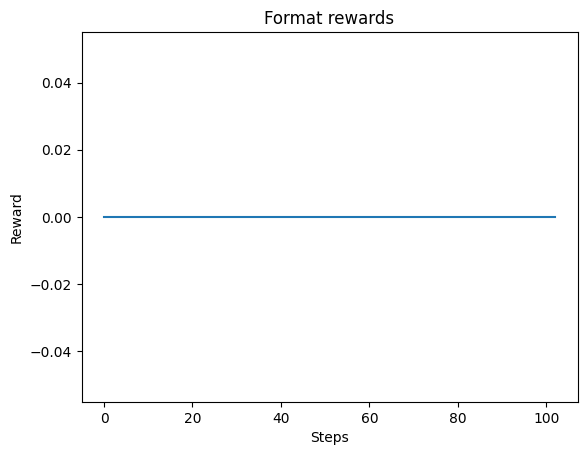

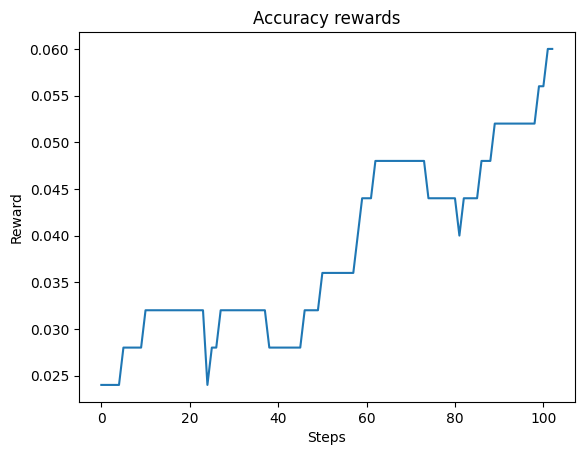

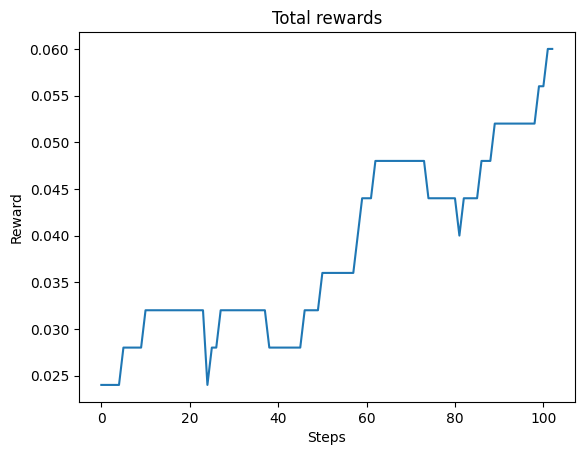

In [27]:
plt.plot(moving_average(track_format_rewards, window_size=100))
plt.title("Format rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(track_accuracy_rewards, window_size=100))
plt.title("Accuracy rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(total_rewards, window_size=100))
plt.title("Total rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()